# Gravitation in PHANTOM
**Test of PHANTOM long-range interaction acceleration**

<!-- @article{PriceEtAl2018,
  title = {{$<$}scp{$>$}{{Phantom}}{$<$}/Scp{$>$}: {{A Smoothed Particle Hydrodynamics}} and {{Magnetohydrodynamics Code}} for {{Astrophysics}}},
  author = {Price, Daniel J. and Wurster, James and Tricco, Terrence S. and Nixon, Chris and Toupin, Stéven and Pettitt, Alex and Chan, Conrad and Mentiplay, Daniel and Laibe, Guillaume and Glover, Simon and Dobbs, Clare and Nealon, Rebecca and Liptai, David and Worpel, Hauke and Bonnerot, Clément and Dipierro, Giovanni and Ballabio, Giulia and Ragusa, Enrico and Federrath, Christoph and Iaconi, Roberto and Reichardt, Thomas and Forgan, Duncan and Hutchison, Mark and Constantino, Thomas and Ayliffe, Ben and Hirsh, Kieran and Lodato, Giuseppe},
  date = {2018},
  journaltitle = {Publications of the Astronomical Society of Australia},
  shortjournal = {Publ. Astron. Soc. Aust.},
  volume = {35},
  number = {2018},
  eprint = {1702.03930},
  eprinttype = {arxiv},
  pages = {e031},
  issn = {1323-3580},
  doi = {10.1017/pasa.2018.25},
  url = {https://www.cambridge.org/core/product/identifier/S1323358018000255/type/journal_article},
  abstract = {We present Phantom , a fast, parallel, modular, and low-memory smoothed particle hydrodynamics and magnetohydrodynamics code developed over the last decade for astrophysical applications in three dimensions. The code has been developed with a focus on stellar, galactic, planetary, and high energy astrophysics, and has already been used widely for studies of accretion discs and turbulence, from the birth of planets to how black holes accrete. Here we describe and test the core algorithms as well as modules for magnetohydrodynamics, self-gravity, sink particles, dust–gas mixtures, H 2 chemistry, physical viscosity, external forces including numerous galactic potentials, Lense–Thirring precession, Poynting–Robertson drag, and stochastic turbulent driving. Phantom is hereby made publicly available.},
  langid = {english},
  keywords = {★, accretion, accretion disks, gravitaion, hydrodynamics, SM: general, agnetohydrodynamics (MHD), methods: numerical, PHANTOM, SPH},
  annotation = {262 citations (Crossref) [2024-03-19]},
  file = {/Users/marat/Yandex.Disk.localized/Documents/Zotero/storage/UB8DW3WQ/Price et al - 2018 - scpPhantom-scp - A Smoothed Particle Hydrodynamics and Magnetohydrodynamics.pdf}
} -->

In [9]:
(* https://mathematica.stackexchange.com/questions/850/how-do-i-clear-all-user-defined-symbols/861#861 *)
<< Utilities`CleanSlate`
CleanSlate[];
ClearAll["Global`*"]
(* ClearSystemCache[] *)
(* https://mathematica.stackexchange.com/questions/111605/quit-vs-clearallglobal *)
if[Length[Names["Global`*"]] > 0, Remove["Global`*"]];

(* PacletInstall[
    "TensorSimplify",
    "Site" -> "http://raw.githubusercontent.com/carlwoll/TensorSimplify/master"
]
<<TensorSimplify` *)

  (CleanSlate) Contexts purged: {Global`}
  (CleanSlate) Approximate kernel memory recovered: 2 Kb


## Einstein Summation

In [17]:
ClearAll@EinsteinSummation

EinsteinSummation[in_List, arrays_] := Module[
  {res =
    isum[in -> Cases[Tally @ Flatten @ in, {_, 1}][[All, 1]], arrays]},
  res /; res =!= $Failed
  ]

EinsteinSummation[in_List -> out_, arrays_] := Module[
  {res = isum[in -> out, arrays]},
  res /; res =!= $Failed
  ]

isum[in_List -> out_, arrays_List] := Catch@Module[
  {indices, contracted, uncontracted, contractions, transpose},
  If[Length[in] != Length[arrays],
    Message[EinsteinSummation::length, Length[in], Length[arrays]];
    Throw[$Failed]];
  MapThread[
    If[IntegerQ@TensorRank[#1] && Length[#1] != TensorRank[#2],
      Message[EinsteinSummation::shape, #1, #2];
      Throw[$Failed]] &, {in, arrays}];
  indices = Tally[Flatten[in, 1]];
  If[DeleteCases[indices, {_, 1 | 2}] =!= {},
    Message[EinsteinSummation::repeat,
      Cases[indices, {x_, Except[1 | 2]} :> x]];
    Throw[$Failed]];
  uncontracted = Cases[indices, {x_, 1} :> x];
  If[Sort[uncontracted] =!= Sort[out],
    Message[EinsteinSummation::output, uncontracted, out];
    Throw[$Failed]];
  contracted = Cases[indices, {x_, 2} :> x];
  contractions = Flatten[Position[Flatten[in, 1], #]] & /@ contracted;
  transpose = FindPermutation[uncontracted, out];
  Activate@
    TensorTranspose[
      TensorContract[Inactive[TensorProduct] @@ arrays, contractions],
      transpose]]

EinsteinSummation::length =
  "Number of index specifications (`1`) does not match the number of \
tensors (`2`)";
EinsteinSummation::shape =
  "Index specification `1` does not match the tensor rank of `2`";
EinsteinSummation::repeat =
  "Index specifications `1` are repeated more than twice";
EinsteinSummation::output =
  "The uncontracted indices don't match the desired output";

In [25]:
(* different variants *)
(* Norm[dx]^2 *)
(* SquareLength[x_] := EinsteinSummation[{{i}, {i}}, {x, x}] *)
SquareLength[x_] := x.x

## Test of partice-node force

### Definitions of vectors

In [29]:
(* r is a distance between particle and node *)
(* M is a mass of the node *)
$Assumptions = {
  _ \[Element] Reals,
  {r, M} \[Element] PositiveReals
};

(* rv is the relative position vector *)
rv = Array[Subscript[r, ##] &, {3}];

(* corresponding unit vector *)
(* ur = Normalize[rv] *)
ur = rv/Sqrt[SquareLength[rv]];

(* unit vector rv with hat *)
(* h means hat *)
urh = Array[Subscript[OverHat[r], ##] &, {3}];

### Quadrupole moments

In [40]:
(* Q is a symmetric tensor, only six independent quantities need to be stored (Qxx, Qxy, Qxz, Qyy, Qyz and Qzz) *)
(* https://mathematica.stackexchange.com/questions/127513/how-to-create-a-symmetric-symbolic-tensor *)
Qij = Normal@ SymmetrizedArray[{i_, j_} -> Subscript[Q, {i, j}], {3, 3}, Symmetric[{1, 2}]];
(* SymmetricMatrixQ[Qij] *)

Qi = FullSimplify[EinsteinSummation[{{j}, {i, j}}, {ur, Qij}]];
Qih = FullSimplify[EinsteinSummation[{{j}, {i, j}}, {urh, Qij}]];

In [232]:
ClearAll@DoCollapse
DoCollapse[f_] :=
  Module[{func = f},
    Expand[
      FullSimplify[
        ReplaceAll[
          func
          , {
          SquareLength[rv] -> r*r
          , rv[[1]] -> urh[[1]]*r
          , rv[[2]] -> urh[[2]]*r
          , rv[[3]] -> urh[[3]]*r
          }
        ]
        (* , Assumptions -> {
          r \[Element] PositiveReals
        } *)
      ]
    ] // MatrixForm
  ]

ClearAll@DoExpand
DoExpand[f_] :=
  Module[{func = f},
    Expand[
      FullSimplify[
        ReplaceAll[
          func
          , {
          Q -> urh.Qih
          , Subscript[Q, 1] -> Qih[[1]]
          , Subscript[Q, 2] -> Qih[[2]]
          , Subscript[Q, 3] -> Qih[[3]]
          (* https://mathematica.stackexchange.com/questions/192416/how-to-avoid-replace-substituting-subscripts *)
          , s_Subscript :> s
          }
        ]
        (* , Assumptions -> {
          r \[Element] PositiveReals
        } *)
      ]
    ] // MatrixForm
  ]

### Eq. 222

^
  M r
     1
-(----)
    2
   r

    ^
  M r
     2
-(----)
    2
   r

    ^
  M r
     3
-(----)
    2
   r
0
         ^
     5 Q r
          1
Q  - ------
 1     2
-----------
     4
    r

         ^
     5 Q r
          2
Q  - ------
 2     2
-----------
     4
    r

         ^
     5 Q r
          3
Q  - ------
 3     2
-----------
     4
    r
0
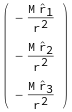
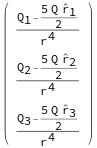

In [242]:
(* from PHANTOM eq. 222 *)
aMPhantom = -M/r^2*urh;
aQPhantom = 1/r^4*Array[(Subscript[Q, #] - 5/2*urh[[#]]*Q) &, {3}];

(* symbolic test *)
aM = -M/SquareLength[rv]*ur;
aQ = 1/SquareLength[rv]^2*(Qi - 5/2*ur*(ur.Qi));

aMPhantom // MatrixForm
FullSimplify[DoExpand[aMPhantom] - DoCollapse[aM]]

aQPhantom // MatrixForm
FullSimplify[DoExpand[aQPhantom] - DoCollapse[aQ]]

### Eq. 226

^ 2        ^  ^             ^  ^
M (-1 + 3 r  )   3 M r  r         3 M r  r
           1          1  2             1  3
--------------   ---------        ---------
       3             3                3
      r             r                r

    ^  ^                   ^ 2        ^  ^
3 M r  r         M (-1 + 3 r  )   3 M r  r
     1  2                   2          2  3
---------        --------------   ---------
    3                   3             3
   r                   r             r

    ^  ^             ^  ^                   ^ 2
3 M r  r         3 M r  r         M (-1 + 3 r  )
     1  3             2  3                   3
---------        ---------        --------------
    3                3                   3
   r                r                   r
0
                                  ^ 2                                         ^  ^
                               35 r                                      35 Q r  r
                ^         5        1                      ^         ^          1  2
Q       - 10 Q  r  + Q (-(-) + ------)     Q       - 5 Q  r  - 5 Q  r  + ----------
 {1, 1}       1  1        2      2          {1, 2}      2  1      1  2       2
--------------------------------------     ----------------------------------------
                   5                                           5
                  r                                           r
 
                                           ^  ^
                                      35 Q r  r
                       ^         ^          1  3
        Q       - 5 Q  r  - 5 Q  r  + ----------
         {1, 3}      3  1      1  3       2
        ----------------------------------------
                            5
>                          r

                                   ^  ^                                      ^ 2
                              35 Q r  r                                   35 r
               ^         ^          1  2                   ^         5        2
Q       - 5 Q  r  - 5 Q  r  + ----------   Q       - 10 Q  r  + Q (-(-) + ------)
 {1, 2}      2  1      1  2       2         {2, 2}       2  2        2      2
----------------------------------------   --------------------------------------
                    5                                         5
                   r                                         r
 
                                           ^  ^
                                      35 Q r  r
                       ^         ^          2  3
        Q       - 5 Q  r  - 5 Q  r  + ----------
         {2, 3}      3  2      2  3       2
        ----------------------------------------
                            5
>                          r

                                   ^  ^                                       ^  ^
                              35 Q r  r                                  35 Q r  r
               ^         ^          1  3                  ^         ^          2  3
Q       - 5 Q  r  - 5 Q  r  + ----------   Q       - 5 Q  r  - 5 Q  r  + ----------
 {1, 3}      3  1      1  3       2         {2, 3}      3  2      2  3       2
----------------------------------------   ----------------------------------------
                    5                                          5
                   r                                          r
 
                                          ^ 2
                                       35 r
                        ^         5        3
        Q       - 10 Q  r  + Q (-(-) + ------)
         {3, 3}       3  3        2      2
        --------------------------------------
                           5
>                         r
0
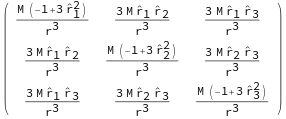
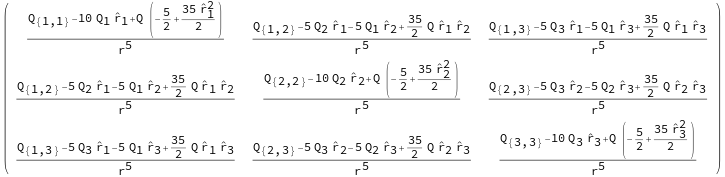

In [252]:
(* from PHANTOM eq. 226 *)
daMPhantom = M/r^3*Array[3*urh[[#]]*urh[[#2]] - KroneckerDelta[#, #2] &, {3, 3}];
daQPhantom = 1/r^5*Array[
  Qij[[#, #2]]
  + (35/2*urh[[#]]*urh[[#2]] - 5/2*KroneckerDelta[#, #2])*Q
  - 5*urh[[#]]*Subscript[Q, #2] - 5*urh[[#2]]*Subscript[Q, #]
  &, {3, 3}];

(* symbolic test *)
daM = D[aM, {rv}];
daQ = D[aQ, {rv}];

daMPhantom // MatrixForm
FullSimplify[DoCollapse[daM] - DoExpand[daMPhantom]]

daQPhantom // MatrixForm
FullSimplify[DoCollapse[daQ] - DoExpand[daQPhantom]]

### Eq. 227

^      ^ 3            ^      ^ 2 ^            ^      ^ 2 ^
-3 M (-3 r  + 5 r  )    -3 M (-r  + 5 r   r )   -3 M (-r  + 5 r   r )
          1      1              2      1   2            3      1   3
--------------------    ---------------------   ---------------------
          4                       4                       4
         r                       r                       r
       ^      ^ 2 ^            ^      ^  ^ 2          ^  ^  ^
-3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )   -15 M r  r  r
        2      1   2            1      1  2            1  2  3
---------------------   ---------------------   --------------
          4                       4                    4
         r                       r                    r
       ^      ^ 2 ^           ^  ^  ^                  ^      ^  ^ 2
-3 M (-r  + 5 r   r )   -15 M r  r  r           -3 M (-r  + 5 r  r  )
        3      1   3           1  2  3                  1      1  3
---------------------   --------------          ---------------------
          4                    4                          4
         r                    r                          r

       ^      ^ 2 ^            ^      ^  ^ 2          ^  ^  ^
-3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )   -15 M r  r  r
        2      1   2            1      1  2            1  2  3
---------------------   ---------------------   --------------
          4                       4                    4
         r                       r                    r
       ^      ^  ^ 2             ^      ^ 3            ^      ^ 2 ^
-3 M (-r  + 5 r  r  )   -3 M (-3 r  + 5 r  )    -3 M (-r  + 5 r   r )
        1      1  2               2      2              3      2   3
---------------------   --------------------    ---------------------
          4                       4                       4
         r                       r                       r
      ^  ^  ^                  ^      ^ 2 ^            ^      ^  ^ 2
-15 M r  r  r           -3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )
       1  2  3                  3      2   3            2      2  3
--------------          ---------------------   ---------------------
       4                          4                       4
      r                          r                       r

       ^      ^ 2 ^           ^  ^  ^                  ^      ^  ^ 2
-3 M (-r  + 5 r   r )   -15 M r  r  r           -3 M (-r  + 5 r  r  )
        3      1   3           1  2  3                  1      1  3
---------------------   --------------          ---------------------
          4                    4                          4
         r                    r                          r
      ^  ^  ^                  ^      ^ 2 ^            ^      ^  ^ 2
-15 M r  r  r           -3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )
       1  2  3                  3      2   3            2      2  3
--------------          ---------------------   ---------------------
       4                          4                       4
      r                          r                       r
       ^      ^  ^ 2           ^      ^  ^ 2             ^      ^ 3
-3 M (-r  + 5 r  r  )   -3 M (-r  + 5 r  r  )   -3 M (-3 r  + 5 r  )
        1      1  3             2      2  3               3      3
---------------------   ---------------------   --------------------
          4                       4                       4
         r                       r                       r
0
                                                                                   ^
                                                                              35 Q r
                                                                                    2
                                                                     (-5 Q  + ------- - 
                                                                          2      2
                                                                      
            
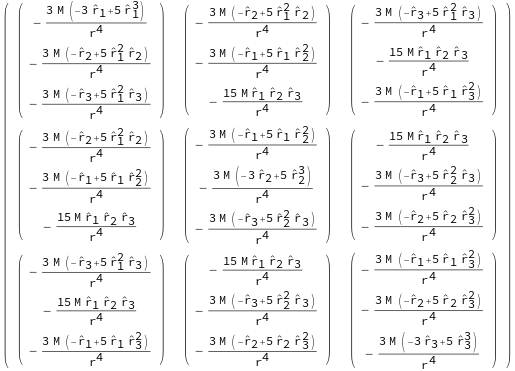
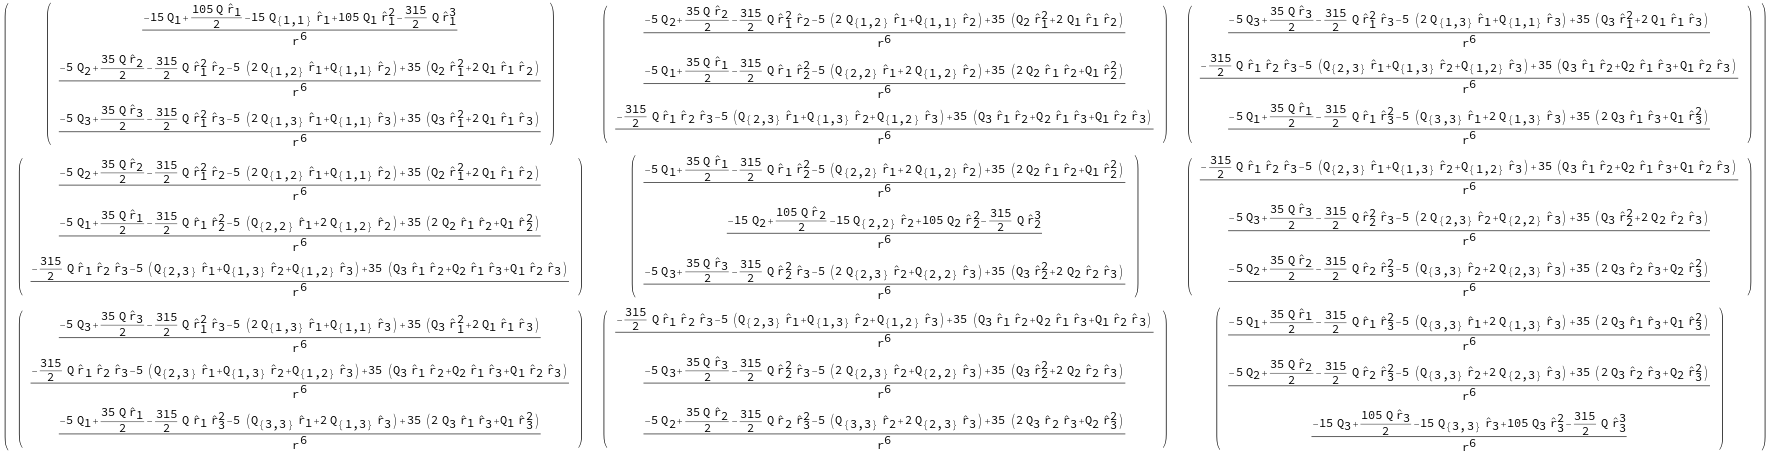

In [262]:
(* from PHANTOM eq. 227 *)
d2aMPhantom = -3*M/r^4*Array[
  5*urh[[#]]*urh[[#2]]*urh[[#3]]
  - KroneckerDelta[#2, #3]*urh[[#]]
  - KroneckerDelta[#, #3]*urh[[#2]]
  - KroneckerDelta[#, #2]*urh[[#3]]
  &, {3, 3, 3}
  ];
d2aQPhantom = 1/r^6*Array[
  - 5*(urh[[#3]]*Qij[[#, #2]] + urh[[#]]*Qij[[#2, #3]] + urh[[#2]]*Qij[[#, #3]])
  - 315/2*urh[[#]]*urh[[#2]]*urh[[#3]]*Q
  + 35/2*(KroneckerDelta[#, #2]*urh[[#3]] + KroneckerDelta[#, #3]*urh[[#2]] + KroneckerDelta[#2, #3]*urh[[#]])*Q
  + 35*(urh[[#2]]*urh[[#3]]*Subscript[Q, #] + urh[[#]]*urh[[#3]]*Subscript[Q, #2] + urh[[#]]*urh[[#2]]*Subscript[Q, #3])
  - 5*(KroneckerDelta[#, #2]*Subscript[Q, #3] + KroneckerDelta[#, #3]*Subscript[Q, #2] + KroneckerDelta[#2, #3]*Subscript[Q, #])
  &, {3, 3, 3}
  ];

(* symbolic test *)
d2aM = D[daM, {rv}];
d2aQ = D[daQ, {rv}];

d2aMPhantom // MatrixForm
FullSimplify[DoCollapse[d2aM] - DoExpand[d2aMPhantom]]

d2aQPhantom // MatrixForm
FullSimplify[DoCollapse[d2aQ] - DoExpand[d2aQPhantom]]

### Conclusion: the formulas are <span style="color:green">correct!</span>

## Checking the symmetry of the node-node interaction force

**Let's take the mass of the particle as unit**

**All particles have equal masses which is enforced in PHANTOM**

In [430]:
(* Drop assumptions *)
$Assumptions = {
  (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
  _ \[Element] Reals
};

(* number of particles in each nodes *)
Np = {1, 2};
(* number of nodes *)
Nn = Length[Np];
(* maximum number of paticles *)
maxNp = Max[Np];

### Definition of dx

0   0   0
Δx         Δx         Δx
  2,1,1      2,1,2      2,1,3

-Δx        -Δx        -Δx
   2,1,1      2,1,2      2,1,3
{2, 2, 3}
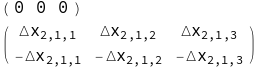

In [449]:
ClearAll@dx
ClearAll@DefineDx

DefineDx[Np_] := Module[
  {
    (* number of nodes *)
    Nn = Length[Np],
    (* maximum number of paticles *)
    maxNp = Max[Np],
    dx0
  },

  (* dx the relative distance of each particle from the node centre of mass *)
  dx0 = Array[Subscript[\[CapitalDelta]x, ##] &, {Nn, maxNp, 3}];
  (* by determining the center of mass of the node *)
  Do[
    dx0[[n, Np[[n]]]] =
    If[
      Np[[n]] <= 1
      , {0, 0, 0}
      , - Sum[dx0[[n, p]], {p, Np[[n]] - 1}]
    ]
    , {n, 1, Nn}
  ];

  dx0
]

dx = DefineDx[Np];

Column[Table[dx[[n, 1;;Np[[n]]]] // MatrixForm, {n, 1, Nn}]]
(* node n, p from n, components dx *)
Dimensions[dx]

### Redefinition of r

r
0          {1, 2}

r
 {1, 2}   0
              ^
              r
0              {1, 2, 1}
              ^
              r
0              {1, 2, 2}
              ^
              r
0              {1, 2, 3}

 ^
-r
  {1, 2, 1}   0
 ^
-r
  {1, 2, 2}   0
 ^
-r
  {1, 2, 3}   0
{_ ∈ Reals, (r       | r      ) ∈ Reals && r       > 0 && r       > 0, 
              {1, 2}    {1, 2}              {1, 2}         {1, 2}
 
    ^         2   ^         2   ^         2
>   r           + r           + r           == 1}
     {1, 2, 1}     {1, 2, 2}     {1, 2, 3}
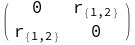
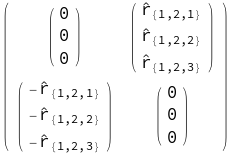

In [458]:
(* distance between nodes *)
ClearAll@r
ClearAll@DefineR

DefineR[Np_] := Module[
  {
    (* number of nodes *)
    Nn = Length[Np],
    (* maximum number of paticles *)
    maxNp = Max[Np],
    rnm0,
    urh0
  },

  rnm0 = Normal@ SymmetrizedArray[{i_, j_} -> Subscript[r, {i, j}], {Nn, Nn}, Symmetric[{1, 2}]];

  (* https://mathematica.stackexchange.com/questions/92666/how-to-zero-or-replace-the-diagonal-of-a-square-matrix *)
  (* rnm0 = ReplacePart[rnm0, {i_, i_} -> 0]; *)
  rnm0 = UpperTriangularize[rnm0, 1] + LowerTriangularize[rnm0, -1];

  (* unit vector r with hat *)
  (* h means hat *)
  urh0 = Normal@ SymmetrizedArray[{i_, j_, k_} -> Subscript[OverHat[r], {i, j, k}], {Nn, Nn, 3}, Antisymmetric[{1, 2}]];

  $Assumptions = {
    (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
    _ \[Element] Reals,
    (* https://mathematica.stackexchange.com/questions/220317/how-to-best-add-assumption-that-many-variables-are-positive *)
    SparseArray[rnm0]["NonzeroValues"] \[Element] PositiveReals
  };
  $Assumptions = Join[
    $Assumptions, Flatten@Table[urh0[[n, m, 1]]^2 + urh0[[n, m, 2]]^2 + urh0[[n, m, 3]]^2 == 1, {n, Nn}, {m, n+1, Nn}]
  ];

  {rnm0, urh0}
]

rAll = DefineR[Np];
rnm = rAll[[1]];
rnm // MatrixForm
urh = rAll[[2]];
urh // MatrixForm

$Assumptions

### Redefinition of quadrupole moments

0   0   0

0   0   0

0   0   0
         2             2          2
4 Δx       - 2 (Δx       + Δx      )    6 Δx      Δx
    2,1,1         2,1,2      2,1,3          2,1,1   2,1,2
 

     6 Δx      Δx
>        2,1,1   2,1,3

                                                   2            2          2
6 Δx      Δx                            -2 (Δx       - 2 Δx       + Δx      )
    2,1,1   2,1,2                             2,1,1        2,1,2      2,1,3
 

     6 Δx      Δx
>        2,1,2   2,1,3


6 Δx      Δx                            6 Δx      Δx
    2,1,1   2,1,3                           2,1,2   2,1,3
 
                2          2            2
     -2 (Δx       + Δx       - 2 Δx      )
>          2,1,1      2,1,2        2,1,3
{2, 3, 3}
True
True
0   0
0   0
0   0

           ^                    ^
6 Δx      (r          Δx      + r          Δx     ) + 
    2,1,1   {1, 2, 2}   2,1,2    {1, 2, 3}   2,1,3
 
    ^                    2             2          2
>   r          (4 Δx       - 2 (Δx       + Δx      ))
     {1, 2, 1}      2,1,1         2,1,2      2,1,3
           ^                    ^
6 Δx      (r          Δx      + r          Δx     ) - 
    2,1,2   {1, 2, 1}   2,1,1    {1, 2, 3}   2,1,3
 
      ^                  2            2          2
>   2 r          (Δx       - 2 Δx       + Δx      )
       {1, 2, 2}    2,1,1        2,1,2      2,1,3
   ^                    ^
6 (r          Δx      + r          Δx     ) Δx      - 
    {1, 2, 1}   2,1,1    {1, 2, 2}   2,1,2    2,1,3
 
      ^                  2          2            2       0
>   2 r          (Δx       + Δx       - 2 Δx      )      0
       {1, 2, 3}    2,1,1      2,1,2        2,1,3        0
{2, 2, 3}
           ^         2     ^         2         2           ^         2         2
    (4 - 6 r           - 6 r          ) Δx       + (-2 + 6 r          ) Δx       + 
            {1, 2, 2}       {1, 2, 3}     2,1,1             {1, 2, 2}     2,1,2
     
           ^          ^                                      ^         2         2
    >   12 r          r          Δx      Δx      + 2 (-1 + 3 r          ) Δx       + 
            {1, 2, 2}  {1, 2, 3}   2,1,2   2,1,3              {1, 2, 3}     2,1,3
     
           ^                   ^                    ^
    >   12 r          Δx      (r          Δx      + r          Δx     )
0           {1, 2, 1}   2,1,1   {1, 2, 2}   2,1,2    {1, 2, 3}   2,1,3

0   0
{2, 2}
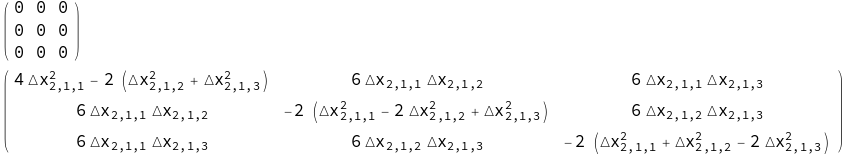
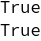
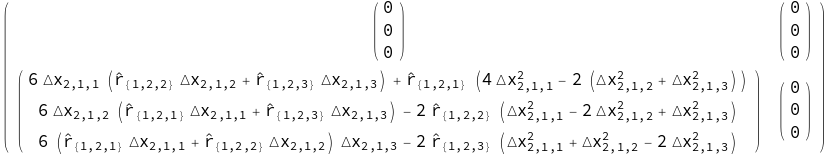
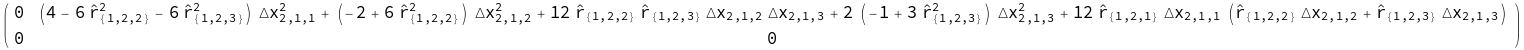

In [467]:
ClearAll@Qij
ClearAll@DefineQij

DefineQij[Np_] := Module[
  {
    (* number of nodes *)
    Nn = Length[Np],
    (* maximum number of paticles *)
    maxNp = Max[Np],
    Qijp,
    Qij0,
    Qi0Full,
    Qi0,
    Q0Full,
    Q0
  },

  Qijp = Array[3*dx[[#, #2, #3]]*dx[[#, #2, #4]] - SquareLength[dx[[#, #2]]]*KroneckerDelta[#3, #4] &, {Nn, maxNp, 3, 3}];
  Qij0 = Array[Subscript[Q, ##] &, {Nn, 3, 3}];
  Do[Qij0[[n]] = FullSimplify[Sum[Qijp[[n, p]], {p, Np[[n]]}]], {n, 1, Nn}];

  Qi0Full = FullSimplify[EinsteinSummation[{{n, m1, j}, {m2, i, j}}, {urh, Qij0}]];
  (* get diagonal *)
  Qi0 = Table[Qi0Full[[All, m, m]], {m, 1, Nn}];

  Q0Full = FullSimplify[EinsteinSummation[{{n1, m1, i}, {n2, m2, j}, {m3, i, j}}, {urh, urh, Qij0}]];
  (* get diagonal *)
  Q0 = Table[Q0Full[[n, m, n, m, m]], {n, 1, Nn}, {m, 1, Nn}];

  {Qij0, Qi0, Q0}
]

QijAll = DefineQij[Np];

Qij = QijAll[[1]];
Column[Table[Qij[[n]] // MatrixForm, {n, 1, Nn}]]
(* node n, components q, components q *)
Dimensions[Qij]

(* Q is a symmetric tensor, only six independent quantities need to be stored (Qxx, Qxy, Qxz, Qyy, Qyz and Qzz) *)
Column[Table[SymmetricMatrixQ[Qij[[n]]] // MatrixForm, {n, 1, Nn}]]

Qi = QijAll[[2]];
Qi // MatrixForm
(* node n, node m, components q *)
Dimensions[Qi]

Q = QijAll[[3]];
Q // MatrixForm
(* node n, node m *)
Dimensions[Q]


### Node_1 <- Node_2 =? Node_2 <- Node_1

#### Eq. 222

In [486]:
(* NB: without r *)

ClearAll@aMPhantom
aMPhantom[Np_] := Array[-Np[[#2]]*urh[[#, #2]] &, {Length[Np], Length[Np]}];

ClearAll@aQPhantom
aQPhantom[Np_] := Array[(Qi[[#, #2, #3]] - 5/2*urh[[#, #2, #3]]*Q[[#, #2]]) &, {Length[Np], Length[Np], 3}];

(* node n, node m, components a *)
Dimensions[aMPhantom[Np]]
Dimensions[aQPhantom[Np]]

{2, 2, 3}
{2, 2, 3}

#### 1 terms in eq. 228

In [488]:
ClearAll@fMPhantom
fMPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^2*Np[[n]]*aMPhantom[Np][[n, m]]

ClearAll@fQPhantom
fQPhantom[Np_, n_, m_] := FullSimplify[1/rnm[[n, m]]^4*Np[[n]]*aQPhantom[Np][[n, m]]]

#### Eq. 226

In [498]:
(* NB: without r *)

ClearAll@daMPhantom
daMPhantom[Np_] := Array[Np[[#2]]*(3*urh[[#, #2, #3]]*urh[[#, #2, #4]] - KroneckerDelta[#3, #4]) &, {Length[Np], Length[Np], 3, 3}];

ClearAll@daQPhantom
daQPhantom[Np_] := Array[
  Qij[[#2, #3, #4]]
  + (35/2*urh[[#, #2, #3]]*urh[[#, #2, #4]] - 5/2*KroneckerDelta[#3, #4])*Q[[#, #2]]
  - 5*urh[[#, #2, #3]]*Qi[[#, #2, #4]] - 5*urh[[#, #2, #4]]*Qi[[#, #2, #3]]
  &, {Length[Np], Length[Np], 3, 3}];

(* node n, node m, components a, components r *)
Dimensions[daMPhantom[Np]]
Dimensions[daQPhantom[Np]]

{2, 2, 3, 3}
{2, 2, 3, 3}

#### 2 terms in eq. 228

In [511]:
ClearAll@a2MPhantomFull
a2MPhantomFull[Np_] := EinsteinSummation[{{n1, p, j}, {n2, m, i, j}}, {dx, daMPhantom[Np]}];
ClearAll@a2MPhantom
(* get diagonal *)
a2MPhantom[Np_] := Table[a2MPhantomFull[Np][[n, All, n]], {n, 1, Length[Np]}];

ClearAll@a2QPhantomFull
a2QPhantomFull[Np_] := EinsteinSummation[{{n1, p, j}, {n2, m, i, j}}, {dx, daQPhantom[Np]}];
ClearAll@a2QPhantom
(* get diagonal *)
a2QPhantom[Np_] := Table[a2QPhantomFull[Np][[n, All, n]], {n, 1, Length[Np]}];

(* node n, p from n, node m, components a *)
Dimensions[a2MPhantom[Np]]
Dimensions[a2QPhantom[Np]]

ClearAll@f2MPhantom
f2MPhantom[Np_, n_, m_] := FullSimplify[1/rnm[[n, m]]^3*Sum[a2MPhantom[Np][[n, p, m]], {p, Np[[n]]}]];

ClearAll@f2QPhantom
f2QPhantom[Np_, n_, m_] := FullSimplify[1/rnm[[n, m]]^5*Sum[a2QPhantom[Np][[n, p, m]], {p, Np[[n]]}]];

{2, 2, 2, 3}
{2, 2, 2, 3}

#### Eq. 227

In [523]:
(* NB: without r *)

ClearAll@d2aMPhantom
d2aMPhantom[Np_] := Array[
  Np[[#]]*
  (5*urh[[#, #2, #3]]*urh[[#, #2, #4]]*urh[[#, #2, #5]]
  - KroneckerDelta[#4, #5]*urh[[#, #2, #3]]
  - KroneckerDelta[#3, #5]*urh[[#, #2, #4]]
  - KroneckerDelta[#3, #4]*urh[[#, #2, #5]])
  &, {Length[Np], Length[Np], 3, 3, 3}
  ];

ClearAll@d2aQPhantom
d2aQPhantom[Np_] := Array[
  - 5*(urh[[#, #2, #5]]*Qij[[#2, #3, #4]] + urh[[#, #2, #3]]*Qij[[#2, #4, #5]] + urh[[#, #2, #4]]*Qij[[#2, #3, #5]])
  - 315/2*urh[[#, #2, #3]]*urh[[#, #2, #4]]*urh[[#, #2, #5]]*Q[[#, #2]]
  + 35/2*(KroneckerDelta[#3, #4]*urh[[#, #2, #5]] + KroneckerDelta[#3, #5]*urh[[#, #2, #4]] + KroneckerDelta[#4, #5]*urh[[#, #2, #3]])*Q[[#, #2]]
  + 35*(urh[[#, #2, #4]]*urh[[#, #2, #5]]*Qi[[#, #2, #3]] + urh[[#, #2, #3]]*urh[[#, #2, #5]]*Qi[[#, #2, #4]] + urh[[#, #2, #3]]*urh[[#, #2, #4]]*Qi[[#, #2, #5]])
  - 5*(KroneckerDelta[#3, #4]*Qi[[#, #2, #5]] + KroneckerDelta[#3, #4]*Qi[[#, #2, #4]] + KroneckerDelta[#4, #5]*Qi[[#, #2, #3]])
  &, {Length[Np], Length[Np], 3, 3, 3}
  ];

(* node n, node m, components a, components r, components r *)
Dimensions[d2aMPhantom[Np]]
TensorRank[d2aMPhantom[Np]]
Dimensions[d2aQPhantom[Np]]
TensorRank[d2aQPhantom[Np]]

{2, 2, 3, 3, 3}
5
{2, 2, 3, 3, 3}
5

#### 3 terms in eq. 228

In [530]:
ClearAll@a3MPhantomFull
a3MPhantomFull[Np_] := 1/2*EinsteinSummation[{{n1, p1, j}, {n2, p2, k}, {n3, m, i, j, k}}, {dx, dx, d2aMPhantom[Np]}];
(* node n, p from n, node n, p from n, node n, node m, components a *)
Dimensions[a3MPhantomFull[Np]]
TensorRank[a3MPhantomFull[Np]]

ClearAll@a3MPhantom
(* get diagonal *)
a3MPhantom[Np_] := Table[a3MPhantomFull[Np][[n, p, n, p, n]], {n, 1, Length[Np]}, {p, 1, Max[Np]}];
(* node n, p from n, node m, components a *)
Dimensions[a3MPhantom[Np]]
TensorRank[a3MPhantom[Np]]

ClearAll@a3QPhantomFull
a3QPhantomFull[Np_] := 1/2*EinsteinSummation[{{n1, p1, j}, {n2, p2, k}, {n3, m, i, j, k}}, {dx, dx, d2aQPhantom[Np]}];
(* node n, p from n, node n, p from n, node n, node m, components a *)
Dimensions[a3QPhantomFull[Np]]
TensorRank[a3QPhantomFull[Np]]

ClearAll@a3QPhantom
(* get diagonal *)
a3QPhantom[Np_] := Table[a3QPhantomFull[Np][[n, p, n, p, n]], {n, 1, Length[Np]}, {p, 1, Max[Np]}];
(* node n, p from n, node m, components a *)
Dimensions[a3QPhantom[Np]]
TensorRank[a3QPhantom[Np]]

ClearAll@f3MPhantom
f3MPhantom[Np_, n_, m_] := FullSimplify[-3/rnm[[n, m]]^4*Sum[a3MPhantom[Np][[n, p, m]], {p, Np[[n]]}]];

ClearAll@f3QPhantom
f3QPhantom[Np_, n_, m_] := FullSimplify[1/rnm[[n, m]]^6*Sum[a3QPhantom[Np][[n, p, m]], {p, Np[[n]]}]];

{2, 2, 2, 2, 2, 2, 3}
7
{2, 2, 2, 3}
4
{2, 2, 2, 2, 2, 2, 3}
7
{2, 2, 2, 3}
4

#### Disbalances

##### 1 term disbalance

{0, 0, 0}
           ^         2     ^         2
(6 (-3 + 5 r           + 5 r          ) Δx      
            {1, 2, 2}       {1, 2, 3}     2,1,1
 
        ^                    ^
>      (r          Δx      + r          Δx     ) + 
         {1, 2, 2}   2,1,2    {1, 2, 3}   2,1,3
 
      ^                    ^         2      ^         2         2
>     r          ((-2 + 15 r           + 15 r          ) Δx       + 
       {1, 2, 1}            {1, 2, 2}        {1, 2, 3}     2,1,1
 
                 ^         2         2      ^          ^
>        (1 - 15 r          ) Δx       - 30 r          r          Δx      Δx      + 
                  {1, 2, 2}     2,1,2        {1, 2, 2}  {1, 2, 3}   2,1,2   2,1,3
 
                 ^         2         2            4
>        (1 - 15 r          ) Δx      )) / r
                  {1, 2, 3}     2,1,3       {1, 2}

    ^         3         2          2
(15 r           (Δx       - Δx      ) + 
     {1, 2, 2}     2,1,1      2,1,2
 
                  ^                    ^
>     12 Δx      (r          Δx      + r          Δx     ) - 
           2,1,2   {1, 2, 1}   2,1,1    {1, 2, 3}   2,1,3
 
         ^         2          ^                    ^
>     30 r           Δx      (r          Δx      + r          Δx     ) + 
          {1, 2, 2}    2,1,2   {1, 2, 1}   2,1,1    {1, 2, 3}   2,1,3
 
      ^                     ^         2         2             2
>     r          ((-14 + 15 r          ) Δx       + 13 Δx       - 
       {1, 2, 2}             {1, 2, 3}     2,1,1         2,1,2
 
            ^          ^                                    ^         2         2
>        30 r          r          Δx      Δx      + (1 - 15 r          ) Δx      )) / 
             {1, 2, 1}  {1, 2, 3}   2,1,1   2,1,3            {1, 2, 3}     2,1,3
 
           4
>   r
     {1, 2}

 ^                     ^         2      ^         2         2
(r          ((-14 + 15 r           + 15 r          ) Δx       - 
  {1, 2, 3}             {1, 2, 2}        {1, 2, 3}     2,1,1
 
            ^          ^                                    ^         2         2
>        30 r          r          Δx      Δx      + (1 - 15 r          ) Δx      ) - 
             {1, 2, 1}  {1, 2, 2}   2,1,1   2,1,2            {1, 2, 2}     2,1,2
 
                ^         2   ^                    ^
>     6 (-2 + 5 r          ) (r          Δx      + r          Δx     ) Δx      + 
                 {1, 2, 3}     {1, 2, 1}   2,1,1    {1, 2, 2}   2,1,2    2,1,3
 
      ^                   ^         2         2           4
>     r          (13 - 15 r          ) Δx      ) / r
       {1, 2, 3}           {1, 2, 3}     2,1,3      {1, 2}
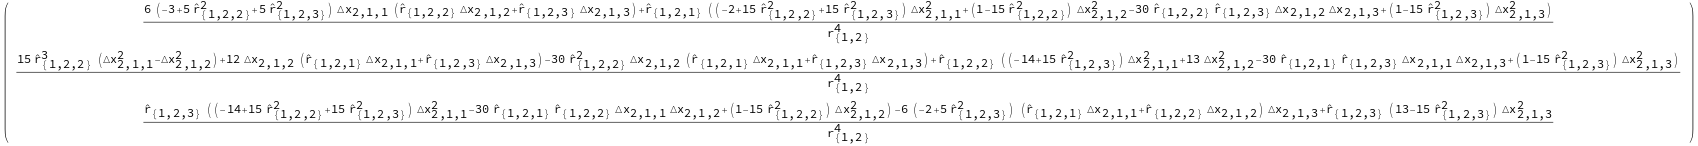

In [553]:
disbalancefM = fMPhantom[Np, 1, 2] + fMPhantom[Np, 2, 1]
disbalancefQ = fQPhantom[Np, 1, 2] + fQPhantom[Np, 2, 1];
FullSimplify[disbalancefQ] // MatrixForm

##### 2 term disbalance

In [556]:
f2MPhantom[Np, 1, 2]
f2MPhantom[Np, 2, 1]
f2QPhantom[Np, 1, 2]
f2QPhantom[Np, 2, 1]

{0, 0, 0}
{0, 0, 0}
{0, 0, 0}
{0, 0, 0}

##### 3 term disbalance

^         3        2              ^                    ^
(6 (5 r           Δx       - 2 Δx      (r          Δx      + r          Δx     ) + 
       {1, 2, 1}    2,1,1        2,1,1   {1, 2, 2}   2,1,2    {1, 2, 3}   2,1,3
 
           ^         2          ^                    ^
>       10 r           Δx      (r          Δx      + r          Δx     ) - 
            {1, 2, 1}    2,1,1   {1, 2, 2}   2,1,2    {1, 2, 3}   2,1,3
 
        ^                    2          ^         2         2
>       r          (3 Δx       + (1 - 5 r          ) Δx       - 
         {1, 2, 1}      2,1,1            {1, 2, 2}     2,1,2
 
              ^          ^                                   ^         2         2
>          10 r          r          Δx      Δx      + (1 - 5 r          ) Δx      ))) / 
               {1, 2, 2}  {1, 2, 3}   2,1,2   2,1,3           {1, 2, 3}     2,1,3
 
           4
>   r
     {1, 2}

      ^         3          2          2
(6 (5 r           (-Δx       + Δx      ) - 
       {1, 2, 2}      2,1,1      2,1,2
 
                   ^                    ^
>       2 Δx      (r          Δx      + r          Δx     ) + 
            2,1,2   {1, 2, 1}   2,1,1    {1, 2, 3}   2,1,3
 
           ^         2          ^                    ^
>       10 r           Δx      (r          Δx      + r          Δx     ) + 
            {1, 2, 2}    2,1,2   {1, 2, 1}   2,1,1    {1, 2, 3}   2,1,3
 
        ^                  ^         2         2            2
>       r          ((4 - 5 r          ) Δx       - 3 Δx       + 
         {1, 2, 2}          {1, 2, 3}     2,1,1        2,1,2
 
              ^          ^                                    ^         2         2
>          10 r          r          Δx      Δx      + (-1 + 5 r          ) Δx      ))) / 
               {1, 2, 1}  {1, 2, 3}   2,1,1   2,1,3            {1, 2, 3}     2,1,3
 
           4
>   r
     {1, 2}

    ^                  ^         2     ^         2         2
(6 (r          ((4 - 5 r           - 5 r          ) Δx       + 
     {1, 2, 3}          {1, 2, 2}       {1, 2, 3}     2,1,1
 
              ^          ^                                    ^         2         2
>          10 r          r          Δx      Δx      + (-1 + 5 r          ) Δx      ) + 
               {1, 2, 1}  {1, 2, 2}   2,1,1   2,1,2            {1, 2, 2}     2,1,2
 
                  ^         2   ^                    ^
>       2 (-1 + 5 r          ) (r          Δx      + r          Δx     ) Δx      + 
                   {1, 2, 3}     {1, 2, 1}   2,1,1    {1, 2, 2}   2,1,2    2,1,3
 
        ^                  ^         2         2            4
>       r          (-3 + 5 r          ) Δx      )) / r
         {1, 2, 3}          {1, 2, 3}     2,1,3       {1, 2}
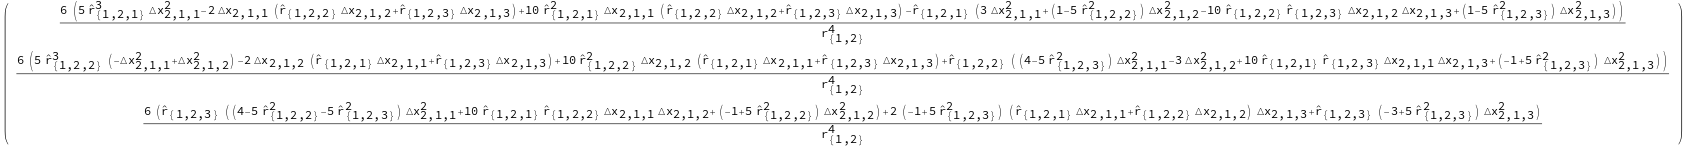

In [567]:
disbalancef3M = f3MPhantom[Np, 1, 2] + f3MPhantom[Np, 2, 1];
FullSimplify[disbalancef3M] // MatrixForm

(* disbalancef3Q = f3QPhantom[Np, 1, 2] + f3QPhantom[Np, 2, 1]; *)
(* FullSimplify[disbalancef3Q] // MatrixForm *)

### Conclusion: node-node interaction are <span style="color:green">symmetric</span> up to 1/r^5!

^                  ^         2     ^         2         2
(5 r          ((2 - 3 r           - 3 r          ) Δx       + 
    {1, 2, 1}          {1, 2, 2}       {1, 2, 3}     2,1,1
 
                ^         2         2     ^          ^
>       (-1 + 3 r          ) Δx       + 6 r          r          Δx      Δx      + 
                 {1, 2, 2}     2,1,2       {1, 2, 2}  {1, 2, 3}   2,1,2   2,1,3
 
                ^         2         2
>       (-1 + 3 r          ) Δx       + 
                 {1, 2, 3}     2,1,3
 
          ^                   ^                    ^                              4
>       6 r          Δx      (r          Δx      + r          Δx     ))) / r
           {1, 2, 1}   2,1,1   {1, 2, 2}   2,1,2    {1, 2, 3}   2,1,3       {1, 2}

   ^                  ^         2     ^         2         2
(5 r          ((2 - 3 r           - 3 r          ) Δx       + 
    {1, 2, 2}          {1, 2, 2}       {1, 2, 3}     2,1,1
 
                ^         2         2     ^          ^
>       (-1 + 3 r          ) Δx       + 6 r          r          Δx      Δx      + 
                 {1, 2, 2}     2,1,2       {1, 2, 2}  {1, 2, 3}   2,1,2   2,1,3
 
                ^         2         2
>       (-1 + 3 r          ) Δx       + 
                 {1, 2, 3}     2,1,3
 
          ^                   ^                    ^                              4
>       6 r          Δx      (r          Δx      + r          Δx     ))) / r
           {1, 2, 1}   2,1,1   {1, 2, 2}   2,1,2    {1, 2, 3}   2,1,3       {1, 2}

   ^                  ^         2     ^         2         2
(5 r          ((2 - 3 r           - 3 r          ) Δx       + 
    {1, 2, 3}          {1, 2, 2}       {1, 2, 3}     2,1,1
 
                ^         2         2     ^          ^
>       (-1 + 3 r          ) Δx       + 6 r          r          Δx      Δx      + 
                 {1, 2, 2}     2,1,2       {1, 2, 2}  {1, 2, 3}   2,1,2   2,1,3
 
                ^         2         2
>       (-1 + 3 r          ) Δx       + 
                 {1, 2, 3}     2,1,3
 
          ^                   ^                    ^                              4
>       6 r          Δx      (r          Δx      + r          Δx     ))) / r
           {1, 2, 1}   2,1,1   {1, 2, 2}   2,1,2    {1, 2, 3}   2,1,3       {1, 2}
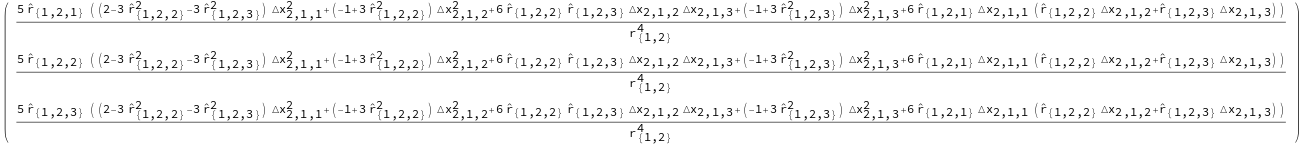

In [565]:
FullSimplify[disbalancefQ + disbalancef3M] // MatrixForm

### Additional force due to disbalance in 1/r^6

4 ^                          3             ^
-360 δy           r            20 δy           δy          r
       {1, 1, 1}   {1, 2, 1}        {1, 1, 1}    {1, 1, 2}  {1, 2, 1}
---------------------------- + -------------------------------------- - 
                 2                                   2
          r                                   r
           {1, 2}                              {1, 2}
 
                   2            2 ^                                      3 ^
    190 δy           δy           r            10 δy          δy           r
          {1, 1, 1}    {1, 1, 2}   {1, 2, 1}        {1, 1, 1}   {1, 1, 2}   {1, 2, 1}
>   ---------------------------------------- - -------------------------------------- - 
                           2                                         2
                    r                                         r
                     {1, 2}                                    {1, 2}
 
                  4 ^                          3             ^
    10 δy           r            20 δy           δy          r
         {1, 1, 2}   {1, 2, 1}        {1, 1, 1}    {1, 1, 3}  {1, 2, 1}
>   -------------------------- + -------------------------------------- - 
                    2                                  2
             r                                  r
              {1, 2}                             {1, 2}
 
                              2             ^
    10 δy          δy           δy          r
         {1, 1, 1}   {1, 1, 2}    {1, 1, 3}  {1, 2, 1}
>   -------------------------------------------------- - 
                                2
                         r
                          {1, 2}
 
                   2            2 ^
    190 δy           δy           r
          {1, 1, 1}    {1, 1, 3}   {1, 2, 1}
>   ---------------------------------------- - 
                           2
                    r
                     {1, 2}
 
                                          2 ^
    10 δy          δy          δy           r
         {1, 1, 1}   {1, 1, 2}   {1, 1, 3}   {1, 2, 1}
>   -------------------------------------------------- - 
                                2
                         r
                          {1, 2}
 
                  2            2 ^                                      3 ^
    20 δy           δy           r            10 δy          δy           r
         {1, 1, 2}    {1, 1, 3}   {1, 2, 1}        {1, 1, 1}   {1, 1, 3}   {1, 2, 1}
>   --------------------------------------- - -------------------------------------- - 
                          2                                         2
                   r                                         r
                    {1, 2}                                    {1, 2}
 
                  4 ^                           2            2 ^
    10 δy           r            160 δy           δy           r
         {1, 1, 3}   {1, 2, 1}         {1, 1, 2}    {2, 1, 1}   {1, 2, 1}
>   -------------------------- - ---------------------------------------- - 
                    2                                   2
             r                                   r
              {1, 2}                              {1, 2}
 
                   2            2 ^                           4 ^
    160 δy           δy           r            360 δy           r
          {1, 1, 3}    {2, 1, 1}   {1, 2, 1}         {2, 1, 1}   {1, 2, 1}
>   ---------------------------------------- + --------------------------- - 
                           2                                   2
                    r                                   r
                     {1, 2}                              {1, 2}
 
                  3             ^                           2            2 ^
    20 δy           δy          r            160 δy           δy           r
         {2, 1, 1}    {2, 1, 2}  {1, 2, 1}         {1, 1, 1}    {2, 1, 2}   {1, 2, 1}
>   -------------------------------------- + ---------------------------------
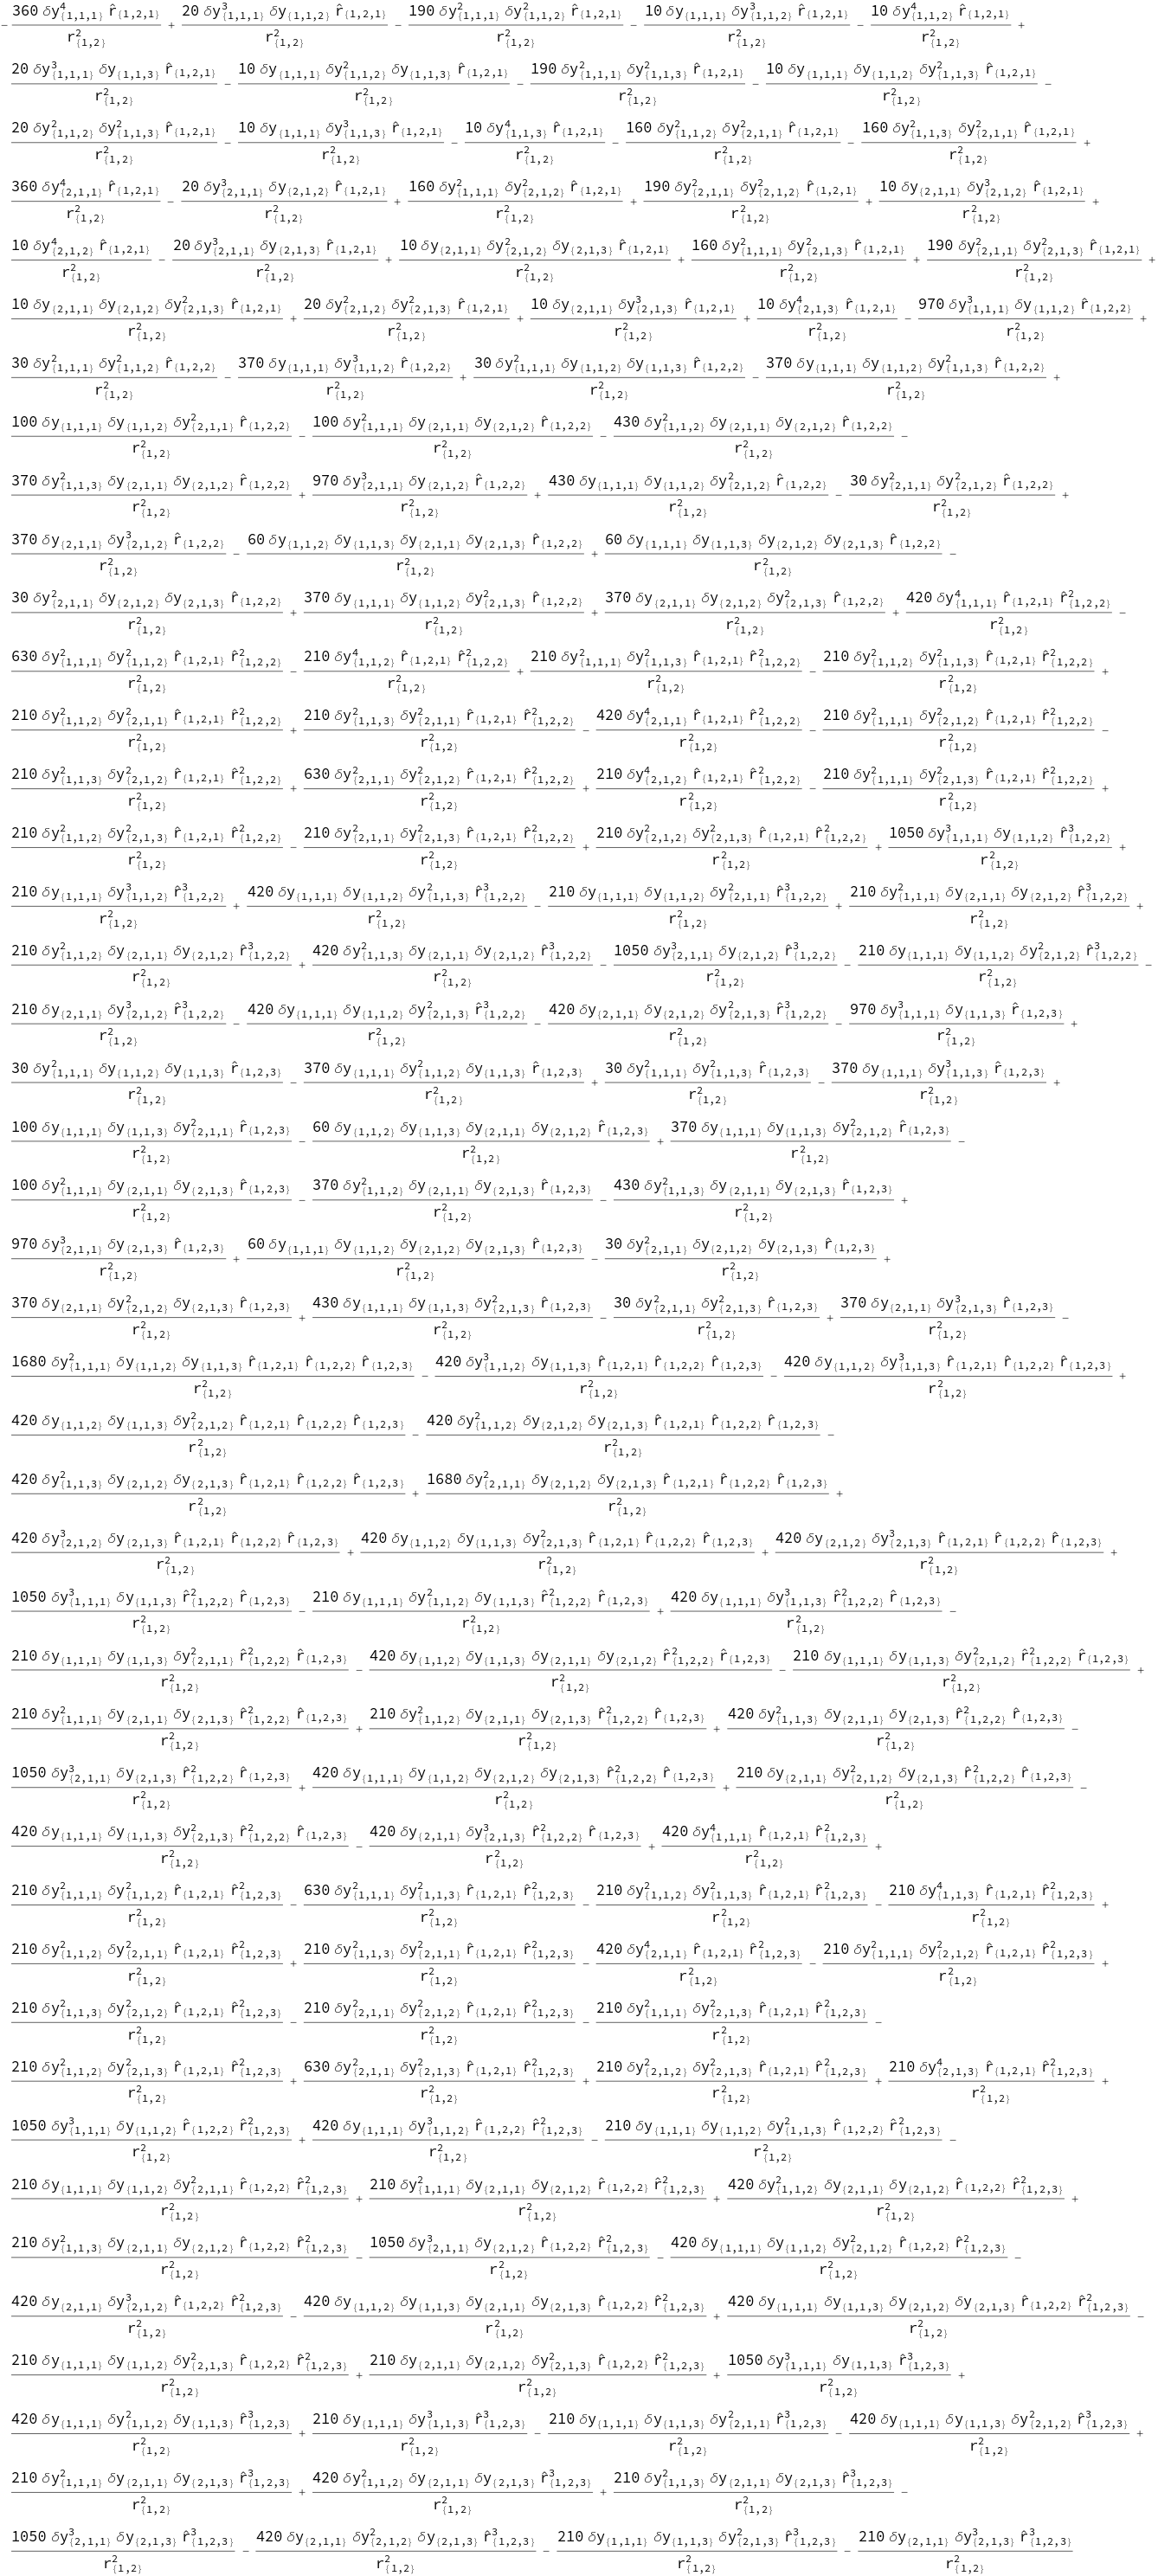

In [396]:
yRules = MapIndexed[
  # -> rnm[[1, 2]]*Subscript[\[Delta]y, Rest[List @@ #1]] &,
  Flatten[Table[dx[[n, 1;;Np[[n]]-1]], {n, 1, Nn}]]
];

disbalancef3Qy = FullSimplify[
  ReplaceAll[
    disbalancef3Q
    , yRules
  ]
];

Expand[FullSimplify[disbalancef3Qy[[1]]]] // MatrixForm

## Additional force due to asymmetry of the tree

0    1    1    1
0    0    0    0
0    0    0    0

-1   0    1    1
0    0    0    0
0    0    0    0

-1   -1   0    1
0    0    0    0
0    0    0    0

-1   -1   -1   0
0    0    0    0
0    0    0    0
0   0   0
           Δx
0            2,1,2    0

           -Δx
0             2,1,2   0
0   0   0
0   0   0
{4, 2, 3}
                                                                    2          2
                            r                           Sqrt[r        + Δx      ]
0                            {1, 2}                           {1, 2}      2,1,2
 
                 2          2
     Sqrt[r        + Δx      ]
>          {1, 2}      2,1,2


r                                                       r
 {1, 2}                     0                            {2, 3}
 

     r
>     {2, 4}

            2          2
Sqrt[r        + Δx      ]   r
      {1, 2}      2,1,2      {2, 3}                     0
 

     r
>     {3, 4}

            2          2
Sqrt[r        + Δx      ]   r                           r
      {1, 2}      2,1,2      {2, 4}                      {3, 4}
 


>    0
0   0   0

0   0   0

0   0   0
          2
-2 Δx
     2,1,2    0             0

                       2
              4 Δx
0                 2,1,2     0

                                      2
                            -2 Δx
0             0                  2,1,2
0   0   0

0   0   0

0   0   0
0   0   0

0   0   0

0   0   0
{4, 3, 3}


0             0             0             0


0             0             0             0


0             0             0             0

          2                          2             2
-2 Δx                       2 Δx          2 Δx
     2,1,2    0                 2,1,2         2,1,2


0             0             0             0


0             0             0             0



0             0             0             0


0             0             0             0


0             0             0             0



0             0             0             0


0             0             0             0


0             0             0             0
{4, 4, 3}
                        2
              -2 Δx
0                  2,1,2    0             0



0             0             0             0

                        2
              -2 Δx
0                  2,1,2    0             0

                        2
              -2 Δx
0                  2,1,2    0             0
{4, 4}
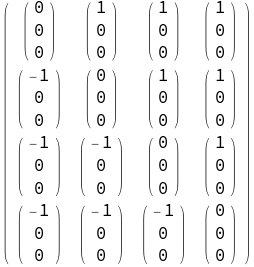
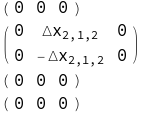
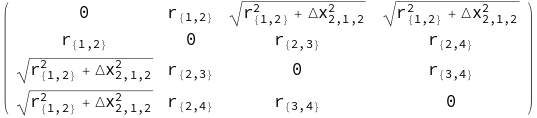
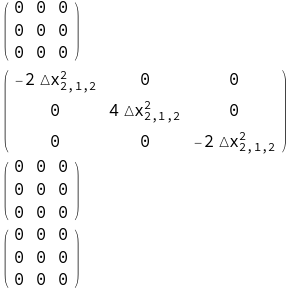
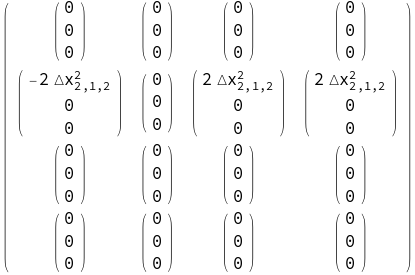
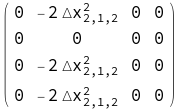

In [636]:
(* Drop assumptions *)
$Assumptions = {
  (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
  _ \[Element] Reals
};

(* system of 4 nodes
A <- B(b1, b2)
b1 <- A
b2 <- A *)
(* Np = {A, B, b1, b2}; *)
Np = {1, 2, 1, 1};
(* number of nodes *)
Nn = Length[Np];
(* maximum number of paticles *)
maxNp = Max[Np];

dx = DefineDx[Np];
rAll = DefineR[Np];
rnm = rAll[[1]];
urh = rAll[[2]];

yRules = MapIndexed[
  # -> rnm[[1, 2]]*Subscript[\[Delta]y, Rest[List @@ #1]] &,
  Flatten[Table[dx[[n, 1;;Np[[n]]-1]], {n, 1, Nn}]]
];

(* Simplification *)

(* all subnodes are collapsed to dot *)
dx[[{1,3;4}, All, All]] = 0;

(* 1 case: Assume all nodes are along the x axis *)
(* FullSimplify[Do[urh[[n, m, {2,3}]] = 0, {n, 1, Length[Np]}, {m, 1, Length[Np]}]];
FullSimplify[Do[urh[[n, m, 1]] = 1, {n, 1, Length[Np]}, {m, n + 1, Length[Np]}]];
FullSimplify[Do[urh[[n, m, 1]] = -1, {m, 1, Length[Np]}, {n, m + 1, Length[Np]}]];
urh //MatrixForm
(* supernode 2 *)
dx[[2, 1;;Np[[3]], All]] = dx[[2, 1, 1]]; (* subnode 3 *)
dx[[2, Np[[3]]+1;;Np[[2]], All]] = -dx[[2, 1, 1]]*Np[[3]]/Np[[4]]; (* subnode 4 *)
dx[[2, All, 2;;3]] = 0;
(* distance between nodes *)
rnm[[1, 3]] = FullSimplify[rnm[[1, 2]] + dx[[2, 1, 1]]];
rnm[[1, 4]] = FullSimplify[rnm[[1, 2]] + dx[[2, Np[[2]], 1]]];
rnm[[3;;4, 1]] = rnm[[1, 3;;4]]; *)

(* 2 case: 1, 2 nodes are along the x axis
  but 3, 4 subnodes of supernode 2 are along the y axis *)
FullSimplify[Do[urh[[n, m, {2,3}]] = 0, {n, 1, Length[Np]}, {m, 1, Length[Np]}]];
FullSimplify[Do[urh[[n, m, 1]] = 1, {n, 1, Length[Np]}, {m, n + 1, Length[Np]}]];
FullSimplify[Do[urh[[n, m, 1]] = -1, {m, 1, Length[Np]}, {n, m + 1, Length[Np]}]];
urh //MatrixForm
(* supernode 2 *)
dx[[2, 1;;Np[[3]], All]] = dx[[2, 1, 2]]; (* subnode 3 *)
dx[[2, Np[[3]]+1;;Np[[2]], All]] = -dx[[2, 1, 2]]*Np[[3]]/Np[[4]]; (* subnode 4 *)
dx[[2, All, {1, 3}]] = 0;
(* distance between nodes *)
rnm[[1, 3]] = Sqrt[rnm[[1, 2]]^2 + dx[[2, 1, 2]]^2];
rnm[[1, 4]] = Sqrt[rnm[[1, 2]]^2 + (dx[[2, 1, 2]]*Np[[3]]/Np[[4]])^2];
rnm[[3;;4, 1]] = rnm[[1, 3;;4]];

Column[Table[dx[[n, 1;;Np[[n]]]] // MatrixForm, {n, 1, Nn}]]
(* node n, p from n, components dx *)
Dimensions[dx]
(* node n, node m *)
rnm // MatrixForm

QijAll = DefineQij[Np];

Qij = QijAll[[1]];
Column[Table[Qij[[n]] // MatrixForm, {n, 1, Nn}]]
(* node n, components q, components q *)
Dimensions[Qij]

Qi = QijAll[[2]];
Qi // MatrixForm
(* node n, components q *)
Dimensions[Qi]

Q = QijAll[[3]];
Q // MatrixForm
(* node n *)
Dimensions[Q]

2
            5 Δx
    -2          2,1,2             2
{-------- + ---------- + -------------------, 0, 0}
        2           4           2          2
 r           r           r        + Δx
  {1, 2}      {1, 2}      {1, 2}      2,1,2
              2                4
 3 δy             2 δy
     {2, 1, 2}        {2, 1, 2}                  6
{-------------- + -------------- + O[δy         ] , 0, 0}
           2                2          {2, 1, 2}
    r                r
     {1, 2}           {1, 2}
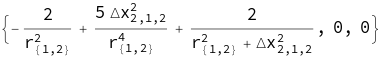
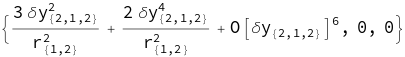

In [666]:
fAFromB = FullSimplify[
  fMPhantom[Np, 1, 2] + fQPhantom[Np, 1, 2] + f3MPhantom[Np, 1, 2] + f3QPhantom[Np, 1, 2]
];
fb1FromA = FullSimplify[
  fMPhantom[Np, 3, 1] + fQPhantom[Np, 3, 1] + f3MPhantom[Np, 3, 1] + f3QPhantom[Np, 3, 1]
];
fb2FromA = FullSimplify[
  fMPhantom[Np, 4, 1] + fQPhantom[Np, 4, 1] + f3MPhantom[Np, 4, 1] + f3QPhantom[Np, 4, 1]
];

addForce = FullSimplify[
  fAFromB + fb1FromA + fb2FromA
  (* Norm[fAFromB + fb1FromA + fb2FromA] *)
]
(* // MatrixForm *)

Series[
  FullSimplify[
    ReplaceAll[
      addForce
      , yRules
    ],
    Thread[Flatten[rnm] >= 0]
  ],
  (* {Subscript[\[Delta]y, {2, 1, 1}], 0, 5} *)
  {Subscript[\[Delta]y, {2, 1, 2}], 0, 5}
]